In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import norm, eigh
import re
import nltk
from nltk.stem.porter import PorterStemmer
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, PCA as sk_learn_PCA
from sklearn.preprocessing import normalize
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne

In [2]:
def script_to_LINES(script, replace_dict={}, drop_words={}):
    LINES = pd.DataFrame(script, columns=['line_str'])
    LINES.index.name = 'line_num'
    LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip() # Replace newlines
    LINES = LINES[LINES['line_str'].str.strip().str.len() > 0] # Drop empty strings
    
    LINES.line_str = LINES.line_str.replace(replace_dict, regex=True) # Replace select words
    LINES = LINES[~LINES['line_str'].isin(drop_words)] # Drop select columns
    
    LINES = LINES.reset_index(drop=True)
    
    return LINES

In [3]:
def assign_page_numbers(lines, page_pat):
    page_number = 1
    page_numbers = []

    for line in lines:
        if re.match(page_pat, line):
            page_number += 1
        page_numbers.append(page_number)

    return page_numbers

In [4]:
def LINES_to_PAGES(LINES, page_pat):
    LINES["page_num"] = assign_page_numbers(LINES.line_str, page_pat)
    LINES = LINES[~LINES['line_str'].str.contains(page_pat, 
                                                  regex=True)].reset_index(drop=True) # Drop lines of just page #
    PAGES = LINES.groupby('page_num')['line_str'].agg(' '.join).reset_index()
    PAGES = PAGES.set_index('page_num')
    return PAGES

In [5]:
def PAGES_to_SENTS(PAGES, sent_pat=r'(?<![MmDd]r)(?<![MmDd]rs)[.?!;:]'):
    SENTS = PAGES['line_str'].str.split(sent_pat, expand=True).stack().to_frame('sent_str')
    SENTS.index.names = ['page_num', 'sent_num']

    SENTS = SENTS[~SENTS['sent_str'].str.match(r'^\s*$')] # Drop only whitespace sents
    SENTS.sent_str = SENTS.sent_str.str.strip()
    return SENTS

In [6]:
def SENTS_to_TOKENS(SENTS, token_pat=r"[\s',-]+"):
    TOKENS = SENTS.sent_str.apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack().to_frame('pos_tuple')
    TOKENS.index.names = ['page_num', 'sent_num', 'token_num']
    TOKENS['pos'] = TOKENS.pos_tuple.apply(lambda x: x[1])
    TOKENS['token_str'] = TOKENS.pos_tuple.apply(lambda x: x[0])
    TOKENS['term_str'] = TOKENS.token_str.str.lower().str.replace(r"\W+", "", regex=True)
    TOKENS['pos_group'] = TOKENS.pos.str[:2]
    
    TOKENS['term_str'] = TOKENS.token_str.replace(r'[\W_]+', '', regex=True).str.lower().str.strip() # Remove non-words
    return TOKENS

In [243]:
data_dict = {
    101: {
        'name': 'mariachiel',
        'title': 'El Mariachi',
        'genre': 'Western',
        'path': './Data/Western/mariachiel.txt',
        'replace_dict': {
            'V.O.': 'VOICEOVER', 
            'INT.': 'INTERIOR, ', 
            'EXT.': 'EXTERIOR, '
        },
        'drop_words': ['CONTINUED', 'CONTINUED:', '(CONTINUED)'],
        'page_pat': r'^\s*\d+\.\s*$'
    },
    102: {
        'name': 'truegrit',
        'title': 'True Grit',
        'genre': 'Western',
        'path': './Data/Western/truegrit.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'\b\d{1,3}\b'
    },
    103: {
        'name': 'wildwildwest',
        'title': 'Wild Wild West',
        'genre': 'Western',
        'path': './Data/Western/wildwildwest.txt',
        'replace_dict': {r'^\d+\s+CONTINUED$', ''},
        'drop_words': ['CONTINUED', 'CONTINUED:', '(CONTINUED)', 'ILD WILD WEST - Rev. 4/9/97'],
        'page_pat': r'^.*\d+\.$'
    },
    104: {
        'name': 'bookofelithe',
        'title': 'The Book of Eli',
        'genre': 'Western',
        'path': './Data/Western/bookofelithe.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': [],
        'page_pat': r'^.*\d+\.$'
    },
    201: {
        'name': 'bladerunner',
        'title': 'Blade Runner',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/bladerunner.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': [],
        'page_pat': r'.*\d+$'
    },    
    202: {
        'name': 'minorityreport',
        'title': 'Minority Report',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/minorityreport.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': ['-----------------------------------------------------------------------------------------------------'],
        'page_pat': r'^.*\d+\.$'
    },    
    203: {
        'name': 'starshiptroopers',
        'title': 'Starship Troopers',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/starshiptroopers.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'^\d+\s'
    },
    204: {
        'name': 'starwarsreturnofthejedi',
        'title': 'Star Wars: Return of the Jedi',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/starwarsreturnofthejedi.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'^\d+\s'
    },
    205 : {
        'name': 'totalrecall',
        'title': 'Total Recall',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/totalrecall.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'^\d+.*'
    },
    301: {
        'name': 'dayofthedead',
        'title': 'Day of the Dead',
        'genre': 'Horror',
        'path': './Data/Horror/dayofthedead.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'^\d+'
    },
    302: {
        'name': 'evildead',
        'title': 'Evil Dead',
        'genre': 'Horror',
        'path': './Data/Horror/evildead.txt',
        'replace_dict': {'^[IE][NTD] -.*$': ''},
        'drop_words': [],
        'page_pat': r'^\d+$'
    },
    303: {
        'name': 'fridaythe13th',
        'title': 'Friday the 13th',
        'genre': 'Horror',
        'path': './Data/Horror/fridaythe13th.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'\d+\s+.*$'
    },
    304: {
        'name': 'insidious',
        'title': 'Insidious',
        'genre': 'Horror',
        'path': './Data/Horror/insidious.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': [],
        'page_pat': r'^\d+\.$'
    },
    305: {
        'name': 'tremors',
        'title': 'Tremors',
        'genre': 'Horror',
        'path': './Data/Horror/tremors.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+.*\d+$'
    },
    401: {
        'name': '500daysofsummer',
        'title': '500 Days of Summer',
        'genre': 'Comedy',
        'path': './Data/Comedy/500daysofsummer.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    402: {
        'name': 'analyzethat',
        'title': 'Analyze That',
        'genre': 'Comedy',
        'path': './Data/Comedy/analyzethat.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    403: {
        'name': 'deathtosmoochy',
        'title': 'Death To Smoochy',
        'genre': 'Comedy',
        'path': './Data/Comedy/deathtosmoochy.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:', 'CONTINUED', 'CONTINUED:', '(CONTINUED)'],
        'page_pat': r'^\d+\.$'
    },
    404: {
        'name': 'dumbanddumber',
        'title': 'Dumb and Dumber',
        'genre': 'Comedy',
        'path': './Data/Comedy/dumbanddumber.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    405: {
        'name': 'shesoutofmyleague',
        'title': "She's Out of My League",
        'genre': 'Comedy',
        'path': './Data/Comedy/shesoutofmyleague.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    501: {
        'name': 'amour',
        'title': 'Amour',
        'genre': 'Romance',
        'path': './Data/Romance/amour.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    502: {
        'name': 'angeleyes',
        'title': 'Angel Eyes',
        'genre': 'Romance',
        'path': './Data/Romance/angeleyes.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:', 'CONTINUED', 'CONTINUED:', '(CONTINUED)'],
        'page_pat': r'^\d+\.$'
    },
    503: {
        'name': 'crazylove',
        'title': 'Crazy Love',
        'genre': 'Romance',
        'path': './Data/Romance/crazylove.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    504: {
        'name': 'faultinourstarsthe',
        'title': 'The Fault in Our Stars',
        'genre': 'Romance',
        'path': './Data/Romance/faultinourstarsthe.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    505: {
        'name': 'walktoremembera',
        'title': 'A Walk to Remember',
        'genre': 'Romance',
        'path': './Data/Romance/walktoremembera.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    }
}

In [244]:
LIB = pd.DataFrame(data_dict).T
LIB

name                          title    genre  \
101               mariachiel                    El Mariachi  Western   
102                 truegrit                      True Grit  Western   
103             wildwildwest                 Wild Wild West  Western   
104             bookofelithe                The Book of Eli  Western   
201              bladerunner                   Blade Runner   Sci-Fi   
202           minorityreport                Minority Report   Sci-Fi   
203         starshiptroopers              Starship Troopers   Sci-Fi   
204  starwarsreturnofthejedi  Star Wars: Return of the Jedi   Sci-Fi   
205              totalrecall                   Total Recall   Sci-Fi   
301             dayofthedead                Day of the Dead   Horror   
302                 evildead                      Evil Dead   Horror   
303            fridaythe13th                Friday the 13th   Horror   
304                insidious                      Insidious   Horror   
305                  tremors                        Tremors   Horror   
401          500daysofsummer             500 Days of Summer   Comedy   
402              analyzethat                   Analyze That   Comedy   
403           deathtosmoochy               Death To Smoochy   Comedy   
404            dumbanddumber                Dumb and Dumber   Comedy   
405        shesoutofmyleague         She's Out of My League   Comedy   
501                    amour                          Amour  Romance   
502                angeleyes                     Angel Eyes  Romance   
503                crazylove                     Crazy Love  Romance   
504       faultinourstarsthe         The Fault in Our Stars  Romance   
505          walktoremembera             A Walk to Remember  Romance   

                                          path  \
101              ./Data/Western/mariachiel.txt   
102                ./Data/Western/truegrit.txt   
103            ./Data/Western/wildwildwest.txt   
104            ./Data/Western/bookofelithe.txt   
201              ./Data/Sci-Fi/bladerunner.txt   
202           ./Data/Sci-Fi/minorityreport.txt   
203         ./Data/Sci-Fi/starshiptroopers.txt   
204  ./Data/Sci-Fi/starwarsreturnofthejedi.txt   
205              ./Data/Sci-Fi/totalrecall.txt   
301             ./Data/Horror/dayofthedead.txt   
302                 ./Data/Horror/evildead.txt   
303            ./Data/Horror/fridaythe13th.txt   
304                ./Data/Horror/insidious.txt   
305                  ./Data/Horror/tremors.txt   
401          ./Data/Comedy/500daysofsummer.txt   
402              ./Data/Comedy/analyzethat.txt   
403           ./Data/Comedy/deathtosmoochy.txt   
404            ./Data/Comedy/dumbanddumber.txt   
405        ./Data/Comedy/shesoutofmyleague.txt   
501                   ./Data/Romance/amour.txt   
502               ./Data/Romance/angeleyes.txt   
503               ./Data/Romance/crazylove.txt   
504      ./Data/Romance/faultinourstarsthe.txt   
505         ./Data/Romance/walktoremembera.txt   

                                          replace_dict  \
101  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
102                                                 {}   
103                              {, ^\d+\s+CONTINUED$}   
104  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
201  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
202  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
203                                                 {}   
204                                                 {}   
205                                                 {}   
301                                                 {}   
302                            {'^[IE][NTD] -.*$': ''}   
303                              {'V.O.': 'VOICEOVER'}   
304  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
305                              {'V.O.': 'VOICEOVER'}   
401  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
402                              {'V.O.': 'V

In [245]:
def id_to_TOKENS(script_id):
    id_data = LIB.loc[script_id]
    path = id_data.path
    script = open(path, 'r').readlines()
    LINES = script_to_LINES(script, replace_dict=id_data.replace_dict, drop_words=id_data.drop_words)
    PAGES = LINES_to_PAGES(LINES, id_data.page_pat)
    SENTS = PAGES_to_SENTS(PAGES)
    TOKENS = SENTS_to_TOKENS(SENTS).reset_index()
    TOKENS['script_id'] = script_id

    TOKENS.set_index(['script_id', 'page_num', 'sent_num', 'token_num'], inplace=True)
    return TOKENS

In [246]:
def LIB_to_CORPUS(LIB):
    CORPUS = pd.DataFrame()
    for script_id in LIB.index:
        CORPUS = pd.concat([CORPUS, id_to_TOKENS(script_id)])
    return CORPUS

In [247]:
CORPUS = LIB_to_CORPUS(LIB)

In [248]:
CORPUS

pos_tuple  pos token_str  \
script_id page_num sent_num token_num                                   
101       1        0        0               (FADE, NN)   NN      FADE   
                            1                (IN, NNP)  NNP        IN   
                   1        0          (EXTERIOR, NNP)  NNP  EXTERIOR   
                            1                   (,, ,)    ,         ,   
                            2                 (A, NNP)  NNP         A   
...                                                ...  ...       ...   
505       122      8        2              (there, RB)   RB     there   
                   11       0               (FADE, CD)   CD      FADE   
                            1                (OUT, RP)   RP       OUT   
                   12       0                (THE, DT)   DT       THE   
                            1                (END, NN)   NN       END   

                                       term_str pos_group  
script_id page_num sent_num token_num                      
101       1        0        0              fade        NN  
                            1                in        NN  
                   1        0          exterior        NN  
                            1                           ,  
                            2                 a        NN  
...                                         ...       ...  
505       122      8        2             there        RB  
                   11       0              fade        CD  
                            1               out        RP  
                   12       0               the        DT  
                            1               end        NN  

[574748 rows x 5 columns]

In [251]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB

n         p          i  n_chars
term_str                                      
           40003  0.069601   3.844749        0
the        28031  0.048771   4.357834        3
a          13083  0.022763   5.457164        1
and        11878  0.020666   5.596566        3
to         11357  0.019760   5.661276        2
...          ...       ...        ...      ...
narrative      1  0.000002  19.132570        9
solace         1  0.000002  19.132570        6
highborn       1  0.000002  19.132570        8
lineage        1  0.000002  19.132570        7
marrying       1  0.000002  19.132570        8

[22217 rows x 4 columns]

In [252]:
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['p_stem'] = VOCAB.apply(lambda x: PorterStemmer().stem(x.name), 1)

In [253]:
sw = pd.DataFrame({'stop': 1}, index=nltk.corpus.stopwords.words('english'))
sw.index.name='term_str'

if 'stop' not in VOCAB.columns:
    VOCAB = VOCAB.join(sw)
    VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [254]:
OHCO = ['script_id', 'page_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:3],
    PAGES = OHCO[:2],
    SCRIPTS = OHCO[:1]
)

In [255]:
def gen_BOW(token_df, bag): # Bag parameter is one of 'SENTS', 'PARAS', 'CHAPS', or 'BOOKS'
    return token_df.groupby(bags[bag]+['term_str']).term_str.count().to_frame('n') 

In [256]:
def BOW_to_TFIDF(BOW, tf_method): # tf_method is 'sum', 'max', 'log', 'raw', 'double_norm', 'binary', or 'df'
    DTCM = BOW.n.unstack(fill_value=0)
    
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)

    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    DF = DTCM.astype('bool').sum() 
    N = DTCM.shape[0]
    IDF = np.log2(N / DF)
    
    if tf_method == 'df':
        return DF * IDF
    
    TF = TF.T
    TFIDF = TF * IDF
    
    return TFIDF

In [257]:
BOW = gen_BOW(CORPUS, "PAGES")
DFIDF = BOW_to_TFIDF(BOW, 'df')

In [258]:
VOCAB = pd.merge(VOCAB, pd.DataFrame(DFIDF), left_index=True, right_index=True, 
         how='inner').rename(columns={0: "DFIDF"})
VOCAB.head(5)

n         p         i  n_chars max_pos_group max_pos p_stem  \
term_str                                                                    
          40003  0.069601  3.844749        0             ,       ,          
the       28031  0.048771  4.357834        3            DT      DT    the   
a         13083  0.022763  5.457164        1            DT      DT      a   
and       11878  0.020666  5.596566        3            CC      CC    and   
to        11357  0.019760  5.661276        2            TO      TO     to   

          stop       DFIDF  
term_str                    
             0  210.833657  
the          1  109.631920  
a            1  488.979512  
and          1  459.973565  
to           1  544.879535

In [263]:
VOCAB.sort_values('DFIDF', ascending=False).head(20).index

Index(['down', 'not', 'me', 'into', 'have', 'there', 'back', 'be', 'they',
       'just', 're', 'looks', 'like', 'one', 'no', 'all', 'then', 'she', 'him',
       'but'],
      dtype='object', name='term_str')

In [208]:
TFIDF = BOW_to_TFIDF(BOW, 'max')

In [209]:
BOW['tfidf'] = TFIDF.stack()
BOW

n     tfidf
script_id page_num term_str               
101       1                   27  0.074923
                   a          23  0.160084
                   across      1  0.124017
                   admiring    1  0.353086
                   alonside    1  0.427160
...                           ..       ...
505       122      the         2  0.037974
                   there       1  0.774456
                   things      1  2.074813
                   voiceover   1  2.278025
                   you         2  0.543935

[321703 rows x 2 columns]

In [210]:
DTCM = BOW.n.unstack(fill_value=0)
DTCM

term_str                0  00  01  0256  03  0300  05  06  07  ...  zone  \
script_id page_num                                             ...         
101       1         27  0   0   0     0   0     0   0   0   0  ...     0   
          2         30  0   0   0     0   0     0   0   0   0  ...     0   
          3         25  0   0   0     0   0     0   0   0   0  ...     0   
          4         32  0   0   0     0   0     0   0   0   0  ...     0   
          5         25  0   0   0     0   0     0   0   0   0  ...     0   
...                 .. ..  ..  ..   ...  ..   ...  ..  ..  ..  ...   ...   
505       118       24  0   0   0     0   0     0   0   0   0  ...     0   
          119       18  0   0   0     0   0     0   0   0   0  ...     0   
          120       23  0   0   0     0   0     0   0   0   0  ...     0   
          121       14  0   0   0     0   0     0   0   0   0  ...     0   
          122        2  0   0   0     0   0     0   0   0   0  ...     0   

term_str            zoned  zoners  zones  zoo  zoological  zoom  zoomed  \
script_id page_num                                                        
101       1             0       0      0    0           0     0       0   
          2             0       0      0    0           0     0       0   
          3             0       0      0    0           0     0       0   
          4             0       0      0    0           0     0       0   
          5             0       0      0    0           0     0       0   
...                   ...     ...    ...  ...         ...   ...     ...   
505       118           0       0      0    0           0     0       0   
          119           0       0      0    0           0     0       0   
          120           0       0      0    0           0     0       0   
          121           0       0      0    0           0     0       0   
          122           0       0      0    0           0     0       0   

term_str            zooms  zwei  
script_id page_num               
101       1             0     0  
          2             0     0  
          3             0     0  
          4             0     0  
          5             0     0  
...                   ...   ...  
505       118           0     0  
          119           0     0  
          120           0     0  
          121           0     0  
          122           0     0  

[2964 rows x 22226 columns]

In [211]:
TFIDF.mean().sort_values(ascending=False).head(20)

term_str
letty      0.125429
i          0.116771
you        0.108006
tom        0.103722
her        0.102465
hazel      0.099096
she        0.098908
landon     0.093348
kirk       0.089668
he         0.089448
his        0.079736
johnny     0.079359
quail      0.077629
michael    0.077045
we         0.075103
nt         0.071996
they       0.070193
lloyd      0.070160
it         0.069996
do         0.069588
dtype: float64

In [212]:
TFIDF_L2 = TFIDF.apply(lambda x: x / np.linalg.norm(x), axis=1)

In [213]:
TFIDF_L2.mean().sort_values(ascending=False).head(20)

term_str
i         0.019384
letty     0.017906
you       0.017618
tom       0.017459
her       0.017386
hazel     0.017217
she       0.017072
landon    0.016734
he        0.015233
sharon    0.013432
his       0.013423
kirk      0.013373
we        0.012331
lloyd     0.012048
nt        0.011925
vitti     0.011643
it        0.011643
harry     0.011551
they      0.011533
do        0.011477
dtype: float64

In [214]:
LIB.reset_index(inplace=True)
LIB.rename(columns={'index': 'script_id'}, inplace=True)

top_1000_nouns = VOCAB[VOCAB.max_pos.isin(['NN', 'NNS'])].sort_values('DFIDF', ascending=False).head(1000).index
TFIDF_reduced = TFIDF_L2[top_1000_nouns]

In [215]:
TFIDF_reduced

term_str              look      door      room      head  time       int  \
script_id page_num                                                         
101       1         0.0000  0.000000  0.000000  0.000000   0.0  0.000000   
          2         0.0000  0.000000  0.000000  0.000000   0.0  0.000000   
          3         0.0000  0.039921  0.000000  0.000000   0.0  0.000000   
          4         0.0000  0.030935  0.000000  0.000000   0.0  0.000000   
          5         0.0000  0.000000  0.000000  0.016073   0.0  0.000000   
...                    ...       ...       ...       ...   ...       ...   
505       118       0.0235  0.000000  0.000000  0.000000   0.0  0.025484   
          119       0.0000  0.000000  0.000000  0.000000   0.0  0.000000   
          120       0.0000  0.000000  0.030733  0.000000   0.0  0.000000   
          121       0.0000  0.000000  0.000000  0.000000   0.0  0.000000   
          122       0.0000  0.000000  0.000000  0.000000   0.0  0.000000   

term_str                eyes       man      hand       way  ...  training  \
script_id page_num                                          ...             
101       1         0.000000  0.000000  0.000000  0.000000  ...       0.0   
          2         0.000000  0.000000  0.026528  0.000000  ...       0.0   
          3         0.000000  0.000000  0.000000  0.000000  ...       0.0   
          4         0.000000  0.017025  0.017214  0.000000  ...       0.0   
          5         0.000000  0.000000  0.016972  0.000000  ...       0.0   
...                      ...       ...       ...       ...  ...       ...   
505       118       0.025959  0.000000  0.000000  0.026897  ...       0.0   
          119       0.000000  0.000000  0.102411  0.000000  ...       0.0   
          120       0.000000  0.032888  0.000000  0.000000  ...       0.0   
          121       0.000000  0.028531  0.000000  0.000000  ...       0.0   
          122       0.124090  0.000000  0.000000  0.000000  ...       0.0   

term_str            bolt      rats  fishing  brakes  toys  cloth  cups  \
script_id page_num                                                       
101       1          0.0  0.000000      0.0     0.0   0.0    0.0   0.0   
          2          0.0  0.000000      0.0     0.0   0.0    0.0   0.0   
          3          0.0  0.000000      0.0     0.0   0.0    0.0   0.0   
          4          0.0  0.000000      0.0     0.0   0.0    0.0   0.0   
          5          0.0  0.050582      0.0     0.0   0.0    0.0   0.0   
...                  ...       ...      ...     ...   ...    ...   ...   
505       118        0.0  0.000000      0.0     0.0   0.0    0.0   0.0   
          119        0.0  0.000000      0.0     0.0   0.0    0.0   0.0   
          120        0.0  0.000000      0.0     0.0   0.0    0.0   0.0   
          121        0.0  0.000000      0.0     0.0   0.0    0.0   0.0   
          122        0.0  0.000000      0.0     0.0   0.0    0.0   0.0   

term_str            transport  gunfire  
script_id page_num                      
101       1               0.0      0.0  
          2               0.0      0.0  
          3               0.0      0.0  
          4               0.0      0.0  
          5               0.0      0.0  
...                       ...      ...  
505       118             0.0      0.0  
          119             0.0      0.0  
          120             0.0      0.0  
          121             0.0      0.0  
          122             0.0      0.0  

[2964 rows x 1000 columns]

In [216]:
def PCA(X, k, norm_docs, center_by_mean, center_by_variance):
    if norm_docs:
        X = (X.T / norm(X, 2, axis=1)).T # L2 norm
    X = X.dropna()
    if center_by_mean:
        X = X - X.mean() # Center term vectors by mean
    elif center_by_variance:
        X = X / X.std() # Center term vectors by std
    COV = X.cov()
    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
    
    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(k).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'
    
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'
    
    DCM = X.dot(COMPS[COV.index].T) 
    
    return LOADINGS, DCM, COMPS

In [217]:
L, D, C = PCA(X=TFIDF_reduced, k=10, norm_docs=True, center_by_mean=False, center_by_variance=False)

In [218]:
D = pd.merge(D, LIB[['script_id', 'title', 'genre']], on='script_id', 
               how='left')

In [219]:
L['PC0'].sort_values(ascending=False).head(5)

term_str
mrs     0.539164
door    0.294064
room    0.267811
int     0.210324
dr      0.189684
Name: PC0, dtype: float64

In [220]:
L['PC1'].sort_values().head(5)

term_str
mrs      -0.684513
mother   -0.096752
truck    -0.051283
group    -0.049388
bug      -0.048962
Name: PC1, dtype: float64

In [221]:
def vis_pcs(M, a, b, label='genre', hover_name='title', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

In [222]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = L.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos_group', 
                      marginal_x='box', height=800)

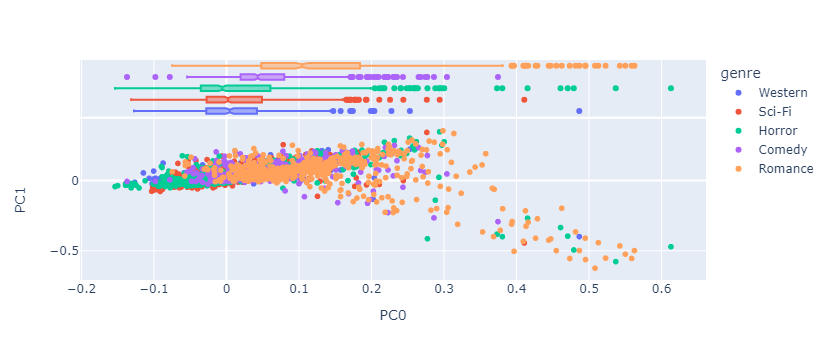

In [223]:
vis_pcs(D, 0, 1)

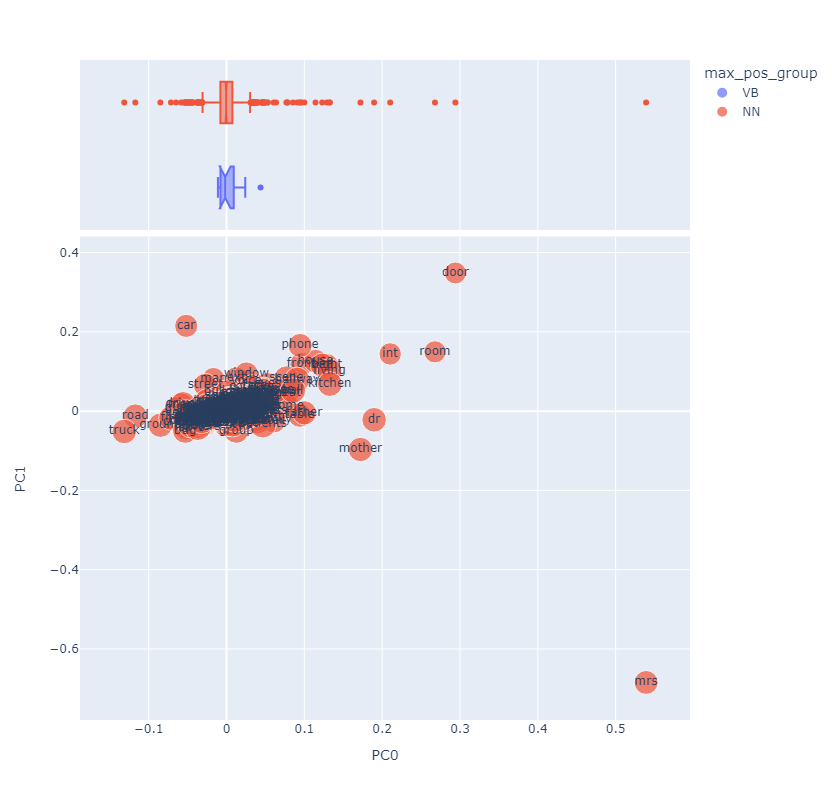

In [224]:
vis_loadings(0, 1)

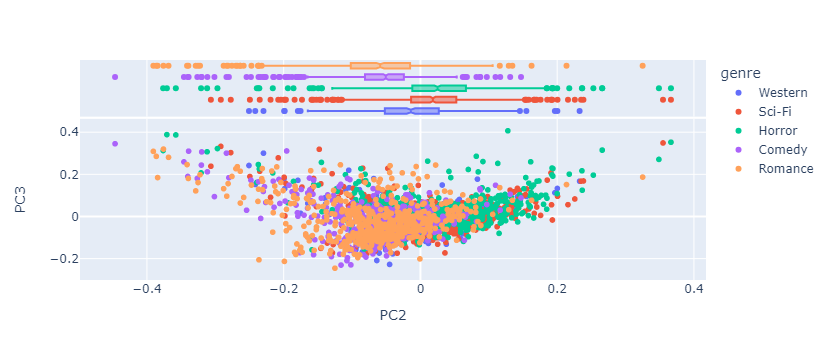

In [225]:
vis_pcs(D, 2, 3)

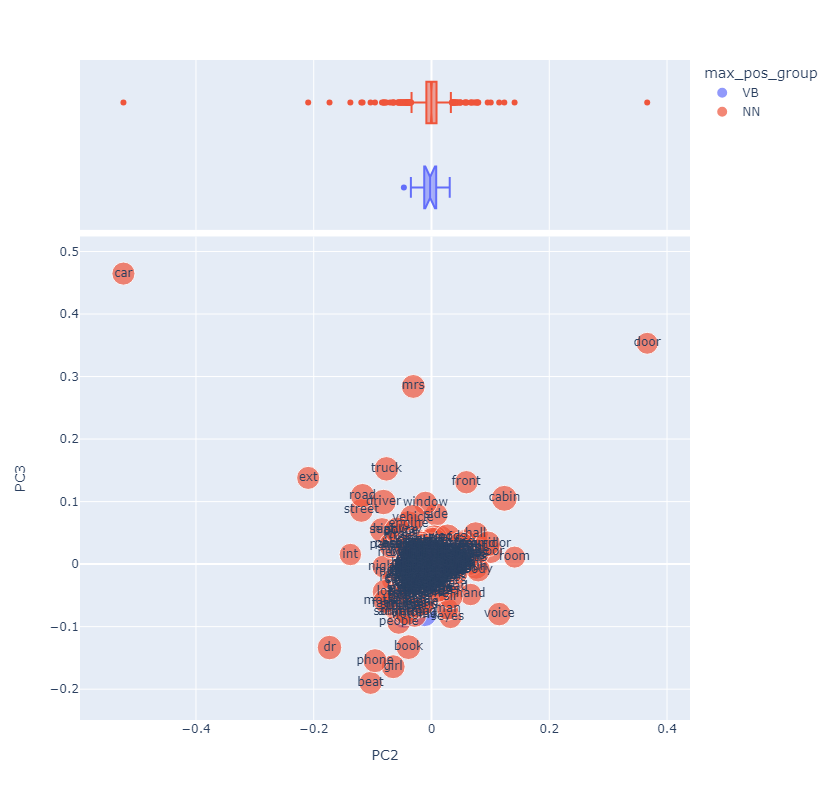

In [226]:
vis_loadings(2, 3)

In [227]:
DOC = pd.merge(CORPUS.reset_index(), LIB[['script_id', 'title', 'genre']], on='script_id', how='left')
DOC

script_id  page_num  sent_num  token_num        pos_tuple  pos  \
0             101         1         0          0       (FADE, NN)   NN   
1             101         1         0          1        (IN, NNP)  NNP   
2             101         1         1          0  (EXTERIOR, NNP)  NNP   
3             101         1         1          1           (,, ,)    ,   
4             101         1         1          2         (A, NNP)  NNP   
...           ...       ...       ...        ...              ...  ...   
574809        505       122         8          2      (there, RB)   RB   
574810        505       122        11          0       (FADE, CD)   CD   
574811        505       122        11          1        (OUT, RP)   RP   
574812        505       122        12          0        (THE, DT)   DT   
574813        505       122        12          1        (END, NN)   NN   

       token_str  term_str pos_group               title    genre  
0           FADE      fade        NN         El Mariachi  Western  
1             IN        in        NN         El Mariachi  Western  
2       EXTERIOR  exterior        NN         El Mariachi  Western  
3              ,                   ,         El Mariachi  Western  
4              A         a        NN         El Mariachi  Western  
...          ...       ...       ...                 ...      ...  
574809     there     there        RB  A Walk to Remember  Romance  
574810      FADE      fade        CD  A Walk to Remember  Romance  
574811       OUT       out        RP  A Walk to Remember  Romance  
574812       THE       the        DT  A Walk to Remember  Romance  
574813       END       end        NN  A Walk to Remember  Romance  

[574814 rows x 11 columns]

In [228]:
DOCS = DOC[DOC.pos.str.match(r'^NNS?$')]\
    .groupby(['script_id', 'page_num']).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [229]:
DOCS

doc_str
script_id page_num                                                   
101       1         fade morning patrol car road parks police car ...
          2         phone rings one watch phone cell block someone...
          3         phone friend people days window sound truck ra...
          4         walk guard hand wad money money partner block ...
          5         phone friends something cellmates cell men dea...
...                                                               ...
505       118       ext sea pink purple blossoms dogwoods wisteria...
          119       kneels height chair pause kneels solidarity so...
          120       rev s kind offense pleasure people sins deligh...
          121       wedding ring pause searches something everythi...
          122                                 mystery things eyes end

[2954 rows x 1 columns]

In [230]:
count_engine = CountVectorizer(max_features=4000, ngram_range=(1, 2), stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

lda_engine = LDA(n_components=20, max_iter=5, learning_offset=50., random_state=0)

TNAMES = [f"T{str(x).zfill(len(str(20)))}" for x in range(20)]

lda_model = lda_engine.fit_transform(count_model)

In [231]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [232]:
THETA.sample(10).T.style.background_gradient(cmap="YlGnBu", axis=None)

In [233]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [234]:
PHI.T.sample(10).style.background_gradient(cmap="YlGnBu", axis=None)

In [235]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(5).reset_index().term_str))\
    .to_frame('top_terms')

TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

TOPICS.sort_values('doc_weight_sum', ascending=False)

top_terms  doc_weight_sum  term_freq
topic_id                                                              
T15                   car man beat eyes way      239.720930   0.084511
T12                 door eyes room man hand      221.221017   0.080874
T06                     int dr door ext rev      179.388823   0.059576
T18                  man head body feet int      178.364664   0.069889
T04                 ext man head summer int      171.185662   0.055755
T03                  way look bar case beat      168.565533   0.054586
T05                  car door hand man road      159.932196   0.055522
T16              water door way people head      146.527200   0.040997
T11                door hand way face floor      145.110552   0.052689
T09                 eyes door mrs room hand      144.318768   0.050857
T01                face door room eyes hand      142.819245   0.052424
T10                  head look car time arm      133.772405   0.044100
T13                truck hand roof gun time      125.855764   0.040486
T17            book mrs dollars people time      118.704771   0.036232
T08            bike phone scout love father      118.654486   0.042517
T00       door scene room scene int georges      117.718043   0.043389
T02                 gun hand beat door head      114.220507   0.036535
T07             carmen hand zander bug bump      111.746454   0.036964
T19                way truck ha street plan      111.487592   0.029555
T14              door head room guard thing      104.685386   0.032543

In [236]:
GENRES = LIB.genre.value_counts().index.to_list()

In [237]:
TOPICS[GENRES] = pd.merge(THETA, LIB[['script_id', 'title', 'genre']], on='script_id', 
               how='left').groupby('genre')[TNAMES].mean().T

In [238]:
TOPICS

top_terms  doc_weight_sum  term_freq  \
topic_id                                                                 
T00       door scene room scene int georges      117.718043   0.043389   
T01                face door room eyes hand      142.819245   0.052424   
T02                 gun hand beat door head      114.220507   0.036535   
T03                  way look bar case beat      168.565533   0.054586   
T04                 ext man head summer int      171.185662   0.055755   
T05                  car door hand man road      159.932196   0.055522   
T06                     int dr door ext rev      179.388823   0.059576   
T07             carmen hand zander bug bump      111.746454   0.036964   
T08            bike phone scout love father      118.654486   0.042517   
T09                 eyes door mrs room hand      144.318768   0.050857   
T10                  head look car time arm      133.772405   0.044100   
T11                door hand way face floor      145.110552   0.052689   
T12                 door eyes room man hand      221.221017   0.080874   
T13                truck hand roof gun time      125.855764   0.040486   
T14              door head room guard thing      104.685386   0.032543   
T15                   car man beat eyes way      239.720930   0.084511   
T16              water door way people head      146.527200   0.040997   
T17            book mrs dollars people time      118.704771   0.036232   
T18                  man head body feet int      178.364664   0.069889   
T19                way truck ha street plan      111.487592   0.029555   

            Sci-Fi    Horror    Comedy   Romance   Western  
topic_id                                                    
T00       0.020052  0.034404  0.077080  0.026708  0.049872  
T01       0.054542  0.047393  0.070459  0.044079  0.018044  
T02       0.039256  0.027887  0.032658  0.054206  0.036628  
T03       0.092758  0.020921  0.060590  0.049772  0.074535  
T04       0.106459  0.036090  0.043937  0.037549  0.080244  
T05       0.049554  0.052399  0.046364  0.054698  0.073502  
T06       0.059048  0.029626  0.158753  0.029669  0.035862  
T07       0.031822  0.035097  0.022549  0.062953  0.027449  
T08       0.046038  0.031599  0.033812  0.049783  0.037762  
T09       0.037922  0.055803  0.050453  0.052243  0.044726  
T10       0.057586  0.026490  0.044280  0.058970  0.036199  
T11       0.046404  0.054081  0.038960  0.049616  0.057840  
T12       0.048249  0.087006  0.072678  0.096250  0.058008  
T13       0.019746  0.081105  0.013731  0.049252  0.038654  
T14       0.020943  0.058033  0.018961  0.053739  0.008344  
T15       0.120868  0.052389  0.087240  0.074031  0.076439  
T16       0.053038  0.091184  0.033138  0.033297  0.026055  
T17       0.032492  0.021317  0.064260  0.033846  0.061365  
T18       0.045398  0.092587  0.016998  0.043806  0.117123  
T19       0.017825  0.064590  0.013100  0.045535  0.041346

In [239]:
TOPICS[GENRES + ['top_terms']].sort_values('Western', ascending=False)

Sci-Fi    Horror    Comedy   Romance   Western  \
topic_id                                                     
T18       0.045398  0.092587  0.016998  0.043806  0.117123   
T04       0.106459  0.036090  0.043937  0.037549  0.080244   
T15       0.120868  0.052389  0.087240  0.074031  0.076439   
T03       0.092758  0.020921  0.060590  0.049772  0.074535   
T05       0.049554  0.052399  0.046364  0.054698  0.073502   
T17       0.032492  0.021317  0.064260  0.033846  0.061365   
T12       0.048249  0.087006  0.072678  0.096250  0.058008   
T11       0.046404  0.054081  0.038960  0.049616  0.057840   
T00       0.020052  0.034404  0.077080  0.026708  0.049872   
T09       0.037922  0.055803  0.050453  0.052243  0.044726   
T19       0.017825  0.064590  0.013100  0.045535  0.041346   
T13       0.019746  0.081105  0.013731  0.049252  0.038654   
T08       0.046038  0.031599  0.033812  0.049783  0.037762   
T02       0.039256  0.027887  0.032658  0.054206  0.036628   
T10       0.057586  0.026490  0.044280  0.058970  0.036199   
T06       0.059048  0.029626  0.158753  0.029669  0.035862   
T07       0.031822  0.035097  0.022549  0.062953  0.027449   
T16       0.053038  0.091184  0.033138  0.033297  0.026055   
T01       0.054542  0.047393  0.070459  0.044079  0.018044   
T14       0.020943  0.058033  0.018961  0.053739  0.008344   

                                  top_terms  
topic_id                                     
T18                  man head body feet int  
T04                 ext man head summer int  
T15                   car man beat eyes way  
T03                  way look bar case beat  
T05                  car door hand man road  
T17            book mrs dollars people time  
T12                 door eyes room man hand  
T11                door hand way face floor  
T00       door scene room scene int georges  
T09                 eyes door mrs room hand  
T19                way truck ha street plan  
T13                truck hand roof gun time  
T08            bike phone scout love father  
T02                 gun hand beat door head  
T10                  head look car time arm  
T06                     int dr door ext rev  
T07             carmen hand zander bug bump  
T16              water door way people head  
T01                face door room eyes hand  
T14              door head room guard thing

In [240]:
TOPICS[GENRES + ['top_terms']].sort_values('Sci-Fi', ascending=False)

Sci-Fi    Horror    Comedy   Romance   Western  \
topic_id                                                     
T15       0.120868  0.052389  0.087240  0.074031  0.076439   
T04       0.106459  0.036090  0.043937  0.037549  0.080244   
T03       0.092758  0.020921  0.060590  0.049772  0.074535   
T06       0.059048  0.029626  0.158753  0.029669  0.035862   
T10       0.057586  0.026490  0.044280  0.058970  0.036199   
T01       0.054542  0.047393  0.070459  0.044079  0.018044   
T16       0.053038  0.091184  0.033138  0.033297  0.026055   
T05       0.049554  0.052399  0.046364  0.054698  0.073502   
T12       0.048249  0.087006  0.072678  0.096250  0.058008   
T11       0.046404  0.054081  0.038960  0.049616  0.057840   
T08       0.046038  0.031599  0.033812  0.049783  0.037762   
T18       0.045398  0.092587  0.016998  0.043806  0.117123   
T02       0.039256  0.027887  0.032658  0.054206  0.036628   
T09       0.037922  0.055803  0.050453  0.052243  0.044726   
T17       0.032492  0.021317  0.064260  0.033846  0.061365   
T07       0.031822  0.035097  0.022549  0.062953  0.027449   
T14       0.020943  0.058033  0.018961  0.053739  0.008344   
T00       0.020052  0.034404  0.077080  0.026708  0.049872   
T13       0.019746  0.081105  0.013731  0.049252  0.038654   
T19       0.017825  0.064590  0.013100  0.045535  0.041346   

                                  top_terms  
topic_id                                     
T15                   car man beat eyes way  
T04                 ext man head summer int  
T03                  way look bar case beat  
T06                     int dr door ext rev  
T10                  head look car time arm  
T01                face door room eyes hand  
T16              water door way people head  
T05                  car door hand man road  
T12                 door eyes room man hand  
T11                door hand way face floor  
T08            bike phone scout love father  
T18                  man head body feet int  
T02                 gun hand beat door head  
T09                 eyes door mrs room hand  
T17            book mrs dollars people time  
T07             carmen hand zander bug bump  
T14              door head room guard thing  
T00       door scene room scene int georges  
T13                truck hand roof gun time  
T19                way truck ha street plan

In [241]:
TOPICS[GENRES + ['top_terms']].sort_values('Horror', ascending=False)

Sci-Fi    Horror    Comedy   Romance   Western  \
topic_id                                                     
T18       0.045398  0.092587  0.016998  0.043806  0.117123   
T16       0.053038  0.091184  0.033138  0.033297  0.026055   
T12       0.048249  0.087006  0.072678  0.096250  0.058008   
T13       0.019746  0.081105  0.013731  0.049252  0.038654   
T19       0.017825  0.064590  0.013100  0.045535  0.041346   
T14       0.020943  0.058033  0.018961  0.053739  0.008344   
T09       0.037922  0.055803  0.050453  0.052243  0.044726   
T11       0.046404  0.054081  0.038960  0.049616  0.057840   
T05       0.049554  0.052399  0.046364  0.054698  0.073502   
T15       0.120868  0.052389  0.087240  0.074031  0.076439   
T01       0.054542  0.047393  0.070459  0.044079  0.018044   
T04       0.106459  0.036090  0.043937  0.037549  0.080244   
T07       0.031822  0.035097  0.022549  0.062953  0.027449   
T00       0.020052  0.034404  0.077080  0.026708  0.049872   
T08       0.046038  0.031599  0.033812  0.049783  0.037762   
T06       0.059048  0.029626  0.158753  0.029669  0.035862   
T02       0.039256  0.027887  0.032658  0.054206  0.036628   
T10       0.057586  0.026490  0.044280  0.058970  0.036199   
T17       0.032492  0.021317  0.064260  0.033846  0.061365   
T03       0.092758  0.020921  0.060590  0.049772  0.074535   

                                  top_terms  
topic_id                                     
T18                  man head body feet int  
T16              water door way people head  
T12                 door eyes room man hand  
T13                truck hand roof gun time  
T19                way truck ha street plan  
T14              door head room guard thing  
T09                 eyes door mrs room hand  
T11                door hand way face floor  
T05                  car door hand man road  
T15                   car man beat eyes way  
T01                face door room eyes hand  
T04                 ext man head summer int  
T07             carmen hand zander bug bump  
T00       door scene room scene int georges  
T08            bike phone scout love father  
T06                     int dr door ext rev  
T02                 gun hand beat door head  
T10                  head look car time arm  
T17            book mrs dollars people time  
T03                  way look bar case beat

In [242]:
TOPICS['genre'] = TOPICS[GENRES].idxmax(1)
TOPICS

top_terms  doc_weight_sum  term_freq  \
topic_id                                                                 
T00       door scene room scene int georges      117.718043   0.043389   
T01                face door room eyes hand      142.819245   0.052424   
T02                 gun hand beat door head      114.220507   0.036535   
T03                  way look bar case beat      168.565533   0.054586   
T04                 ext man head summer int      171.185662   0.055755   
T05                  car door hand man road      159.932196   0.055522   
T06                     int dr door ext rev      179.388823   0.059576   
T07             carmen hand zander bug bump      111.746454   0.036964   
T08            bike phone scout love father      118.654486   0.042517   
T09                 eyes door mrs room hand      144.318768   0.050857   
T10                  head look car time arm      133.772405   0.044100   
T11                door hand way face floor      145.110552   0.052689   
T12                 door eyes room man hand      221.221017   0.080874   
T13                truck hand roof gun time      125.855764   0.040486   
T14              door head room guard thing      104.685386   0.032543   
T15                   car man beat eyes way      239.720930   0.084511   
T16              water door way people head      146.527200   0.040997   
T17            book mrs dollars people time      118.704771   0.036232   
T18                  man head body feet int      178.364664   0.069889   
T19                way truck ha street plan      111.487592   0.029555   

            Sci-Fi    Horror    Comedy   Romance   Western    genre  
topic_id                                                             
T00       0.020052  0.034404  0.077080  0.026708  0.049872   Comedy  
T01       0.054542  0.047393  0.070459  0.044079  0.018044   Comedy  
T02       0.039256  0.027887  0.032658  0.054206  0.036628  Romance  
T03       0.092758  0.020921  0.060590  0.049772  0.074535   Sci-Fi  
T04       0.106459  0.036090  0.043937  0.037549  0.080244   Sci-Fi  
T05       0.049554  0.052399  0.046364  0.054698  0.073502  Western  
T06       0.059048  0.029626  0.158753  0.029669  0.035862   Comedy  
T07       0.031822  0.035097  0.022549  0.062953  0.027449  Romance  
T08       0.046038  0.031599  0.033812  0.049783  0.037762  Romance  
T09       0.037922  0.055803  0.050453  0.052243  0.044726   Horror  
T10       0.057586  0.026490  0.044280  0.058970  0.036199  Romance  
T11       0.046404  0.054081  0.038960  0.049616  0.057840  Western  
T12       0.048249  0.087006  0.072678  0.096250  0.058008  Romance  
T13       0.019746  0.081105  0.013731  0.049252  0.038654   Horror  
T14       0.020943  0.058033  0.018961  0.053739  0.008344   Horror  
T15       0.120868  0.052389  0.087240  0.074031  0.076439   Sci-Fi  
T16       0.053038  0.091184  0.033138  0.033297  0.026055   Horror  
T17       0.032492  0.021317  0.064260  0.033846  0.061365   Comedy  
T18       0.045398  0.092587  0.016998  0.043806  0.117123  Western  
T19       0.017825  0.064590  0.013100  0.045535  0.041346   Horror

In [59]:
pca_engine_phi = sk_learn_PCA(2)

In [60]:
PHI_COMPS = pd.DataFrame(pca_engine_phi.fit_transform(normalize(PHI, norm='l2', axis=1)), index=PHI.index)
PHI_COMPS['mean_doc_weight'] = THETA.mean()
PHI_COMPS

0         1  mean_doc_weight
topic_id                                     
T00       0.453942  0.159644         0.035854
T01      -0.301037  0.218540         0.055343
T02       0.053738 -0.126885         0.048100
T03       0.355679  0.175608         0.036244
T04       0.099244  0.363559         0.054365
T05      -0.039294 -0.027274         0.063994
T06      -0.135693 -0.153087         0.036916
T07      -0.139045  0.289286         0.041100
T08       0.147345 -0.119965         0.069569
T09      -0.286014  0.164512         0.046452
T10       0.494926  0.033453         0.075300
T11      -0.282050 -0.265927         0.064127
T12       0.095699 -0.305236         0.055504
T13       0.083862 -0.003699         0.048510
T14       0.004670 -0.060737         0.041764
T15      -0.103588 -0.216146         0.055077
T16       0.026180 -0.147076         0.047470
T17      -0.298724  0.518919         0.042953
T18      -0.328195 -0.254021         0.033508
T19       0.098356 -0.243467         0.047849

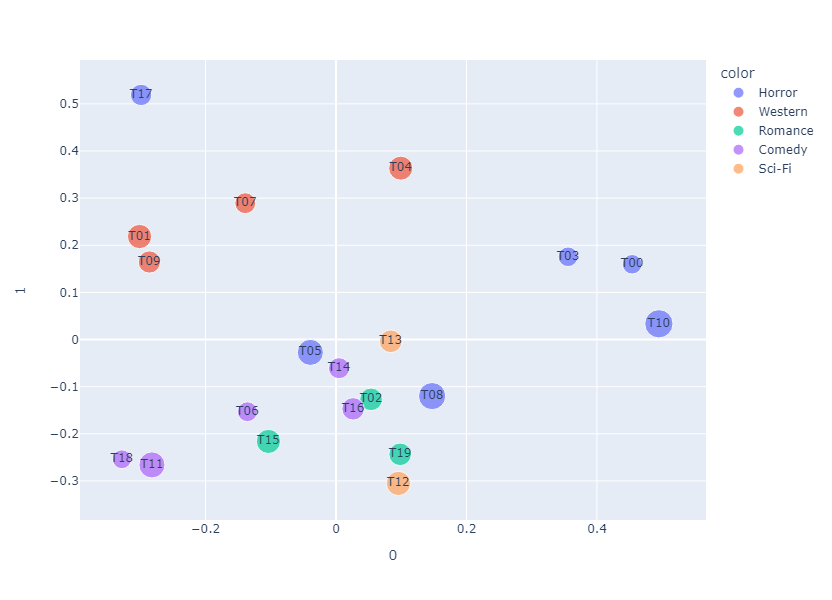

In [61]:
px.scatter(PHI_COMPS.reset_index(), 0, 1, 
           size='mean_doc_weight', 
           color=TOPICS.genre, 
           text='topic_id', hover_name=TOPICS.top_terms, height=600, width=700)

In [62]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

In [63]:
SALEX = pd.read_csv("salex_nrc.csv").set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  sentiment  
term_str                                          
abandon            1         0      0         -1  
abandoned          1         0      0         -1  
abandonment        1         1      0         -1  
abduction          1         1      0         -1  
aberration         0         0      0         -1  
...              ...       ...    ...        ...  
young              0         1      0          1  
youth              0         1      0          1  
zeal               0         1      1          1  
zealous            0         0      1          1  
zest               0         0      1          1  

[3688 rows x 11 columns]

In [64]:
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)
V

n         p          i  n_chars max_pos_group max_pos  \
term_str                                                                
harry         624  0.001254   9.639286        5            NN     NNP   
interior      580  0.001166   9.744779        8            NN     NNP   
good          533  0.001071   9.866696        4            JJ      JJ   
gun           274  0.000551  10.826656        3            NN      NN   
love          223  0.000448  11.123788        4            VB     VBP   
...           ...       ...        ...      ...           ...     ...   
gush            1  0.000002  18.924688        4            VB     VBP   
airs            1  0.000002  18.924688        4            NN     NNS   
unlucky         1  0.000002  18.924688        7            JJ      JJ   
scrimmage       1  0.000002  18.924688        9            NN      NN   
difficulties    1  0.000002  18.924688       12            NN     NNS   

                  p_stem  stop       DFIDF  anger  anticipation  disgust  \
term_str                                                                   
harry              harri     0  480.941155      1             0        0   
interior        interior     0  866.926987      0             0        1   
good                good     0  978.364507      0             1        0   
gun                  gun     0  636.507386      1             0        0   
love                love     0  596.113121      0             0        0   
...                  ...   ...         ...    ...           ...      ...   
gush                gush     0   11.153552      0             0        1   
airs                 air     0   11.153552      0             0        1   
unlucky          unlucki     0   11.153552      1             0        1   
scrimmage       scrimmag     0   11.153552      0             0        0   
difficulties  difficulti     0   11.153552      0             0        0   

              fear  joy  negative  positive  sadness  surprise  trust  \
term_str                                                                
harry            0    0         1         0        1         0      0   
interior         0    0         0         1        0         0      1   
good             0    1         0         1        0         1      1   
gun              1    0         1         0        0         0      0   
love             0    1         0         1        0         0      0   
...            ...  ...       ...       ...      ...       ...    ...   
gush             0    1         1         0        0         0      0   
airs             0    0         1         0        0         0      0   
unlucky          1    0         1         0        1         0      0   
scrimmage        0    0         1         0        0         1      0   
difficulties     0    0         1         0        1         0      0   

              sentiment  
term_str                 
harry                -1  
interior              1  
good                  1  
gun                  -1  
love                  1  
...                 ...  
gush                 -1  
airs                 -1  
unlucky              -1  
scrimmage            -1  
difficulties         -1  

[1976 rows x 20 columns]

In [65]:
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()
B

n     tfidf max_pos  anger  anticipation  \
script_id page_num term_str                                              
101       1        dirty      1  0.253023      NN    0.0           0.0   
                   food       2  0.367684      NN    0.0           0.0   
                   gentleman  1  0.327097      NN    0.0           0.0   
                   gorgeous   1  0.309118      JJ    0.0           0.0   
                   interior   4  0.438340     NNP    0.0           0.0   
...                          ..       ...     ...    ...           ...   
504       114      worry      1  0.155018      VB    0.0           1.0   
                   worthless  1  0.290101      JJ    1.0           0.0   
          115      black      1  0.364909      JJ    0.0           0.0   
                   hope       1  0.453057     VBP    0.0           1.0   
                   hurt       1  0.486018      VB    1.0           0.0   

                              disgust  fear  joy  sadness  surprise  trust  \
script_id page_num term_str                                                  
101       1        dirty          1.0   0.0  0.0      0.0       0.0    0.0   
                   food           0.0   0.0  1.0      0.0       0.0    1.0   
                   gentleman      0.0   0.0  0.0      0.0       0.0    1.0   
                   gorgeous       0.0   0.0  1.0      0.0       0.0    0.0   
                   interior       1.0   0.0  0.0      0.0       0.0    1.0   
...                               ...   ...  ...      ...       ...    ...   
504       114      worry          0.0   1.0  0.0      1.0       0.0    0.0   
                   worthless      1.0   0.0  0.0      1.0       0.0    0.0   
          115      black          0.0   0.0  0.0      1.0       0.0    0.0   
                   hope           0.0   0.0  1.0      0.0       1.0    1.0   
                   hurt           0.0   1.0  0.0      1.0       0.0    0.0   

                              sentiment  
script_id page_num term_str              
101       1        dirty           -1.0  
                   food             1.0  
                   gentleman        1.0  
                   gorgeous         1.0  
                   interior         1.0  
...                                 ...  
504       114      worry           -1.0  
                   worthless       -1.0  
          115      black           -1.0  
                   hope             1.0  
                   hurt            -1.0  

[18912 rows x 12 columns]

In [66]:
pd.merge(B.reset_index().groupby('script_id')['sentiment'].mean(), 
         LIB[['script_id', 'title', 'genre']], on="script_id").sort_values('sentiment')

script_id  sentiment                          title    genre
9         302  -0.390000                      Evil Dead   Horror
8         301  -0.302502                Day of the Dead   Horror
15        404  -0.153380                Dumb and Dumber   Comedy
1         102  -0.139344                      True Grit  Western
7         204  -0.105613  Star Wars: Return of the Jedi   Sci-Fi
13        402  -0.096314                   Analyze That   Comedy
11        304  -0.089900                      Insidious   Horror
4         201  -0.089172                   Blade Runner   Sci-Fi
10        303  -0.088083                Friday the 13th   Horror
3         104  -0.070922                The Book of Eli  Western
2         103  -0.070356                 Wild Wild West  Western
17        502  -0.063677                     Angel Eyes  Romance
0         101  -0.050813                    El Mariachi  Western
6         203  -0.050123              Starship Troopers   Sci-Fi
19        504   0.009165         The Fault in Our Stars  Romance
14        403   0.025916               Death To Smoochy   Comedy
5         202   0.032730                Minority Report   Sci-Fi
16        501   0.066098                          Amour  Romance
18        503   0.150000                     Crazy Love  Romance
12        401   0.196009             500 Days of Summer   Comedy

In [67]:
star_wars_pages = B.reset_index()[B.reset_index()['script_id'] == 103].groupby('page_num')[emo_cols].mean()
star_wars_pages

anger  anticipation   disgust      fear       joy   sadness  \
page_num                                                                   
1         0.157895      0.105263  0.263158  0.578947  0.105263  0.368421   
2         0.555556      0.444444  0.555556  0.555556  0.333333  0.555556   
3         0.000000      0.285714  0.428571  0.000000  0.285714  0.071429   
4         0.434783      0.173913  0.173913  0.391304  0.130435  0.260870   
5         0.000000      0.166667  0.166667  0.166667  0.500000  0.000000   
...            ...           ...       ...       ...       ...       ...   
112       0.466667      0.400000  0.200000  0.333333  0.266667  0.133333   
113       0.269231      0.269231  0.211538  0.423077  0.326923  0.269231   
115       0.222222      0.444444  0.111111  0.222222  0.222222  0.222222   
116       0.333333      0.166667  0.166667  0.500000  0.500000  0.166667   
117       0.000000      0.333333  0.333333  0.000000  0.333333  0.000000   

          surprise     trust  sentiment  
page_num                                 
1         0.052632  0.210526  -0.315789  
2         0.555556  0.333333  -0.222222  
3         0.214286  0.428571   0.000000  
4         0.217391  0.260870  -0.347826  
5         0.166667  0.333333   0.500000  
...            ...       ...        ...  
112       0.066667  0.400000  -0.066667  
113       0.269231  0.346154  -0.134615  
115       0.222222  0.444444   0.555556  
116       0.333333  0.666667   0.333333  
117       0.000000  0.000000   0.333333  

[115 rows x 9 columns]

In [68]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

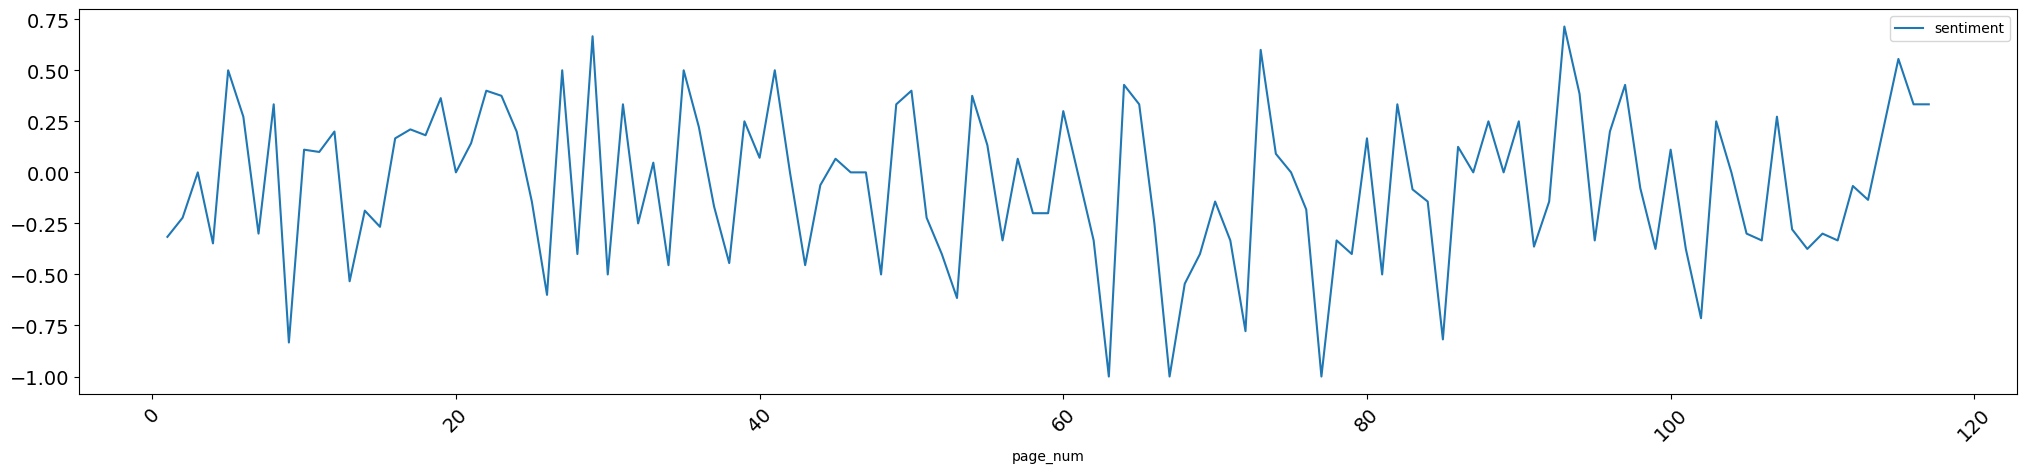

In [69]:
plot_sentiments(star_wars_pages, ['sentiment'])

In [70]:
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [71]:
docs = CORPUS[~CORPUS.pos.str.match('NNPS?')].dropna(subset=['term_str']).groupby(['script_id', 'page_num']).term_str\
    .apply(lambda  x:  x.tolist()).reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]

In [72]:
vocab = Dictionary(docs)

In [73]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [74]:
model.wv.vectors

array([[ 0.1762033 , -0.06864318,  0.13193032, ..., -0.08076809,
        -0.1070779 ,  0.2516475 ],
       [ 0.14262564, -0.2837369 ,  0.2749772 , ...,  0.05830117,
         0.14998746, -0.05475899],
       [ 0.03160657, -0.43522352,  0.5771705 , ...,  0.02276656,
        -0.18703125,  0.0111213 ],
       ...,
       [-0.01130063, -0.09955378,  0.06550267, ...,  0.02601973,
         0.08938239, -0.03792849],
       [ 0.00293323, -0.13528845,  0.10066351, ...,  0.01968382,
         0.09146821, -0.00707267],
       [-0.08338687, -0.00678455,  0.09561671, ...,  0.01951283,
         0.04676463, -0.09104145]], dtype=float32)

In [75]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [76]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [77]:
WV

0         1         2         3         4         5    \
term_str                                                               
          0.176203 -0.068643  0.131930  0.309547 -0.638591 -0.402577   
the       0.142626 -0.283737  0.274977 -0.332429 -0.101272  0.065642   
a         0.031607 -0.435224  0.577170 -0.177343 -0.415209 -0.319202   
and      -0.121514 -0.070862  0.081857 -0.109301  0.142462  0.332248   
to       -0.118498 -0.192818 -0.829000  0.194713 -0.024061  0.549937   
...            ...       ...       ...       ...       ...       ...   
sets     -0.064368 -0.048110  0.127222 -0.089018  0.007585  0.014669   
touches  -0.105793 -0.036548  0.047818 -0.030342  0.038338  0.062099   
beyond    0.054963 -0.052204  0.134535 -0.084588 -0.070365 -0.008591   
sleeping -0.006984 -0.095920  0.163445 -0.071046 -0.133906 -0.058417   
remains  -0.043156 -0.025927  0.163217 -0.070456  0.010425  0.035358   

               6         7         8         9    ...       236       237  \
term_str                                          ...                       
         -0.085541 -0.074778 -0.129767 -0.559399  ...  0.037329 -0.430160   
the      -0.193512 -0.139577 -0.450045 -0.062486  ... -0.203716  0.158615   
a        -0.341040 -0.047337 -0.757962  0.368418  ...  0.256661 -0.188575   
and       0.122186  0.163996  0.350892  0.089826  ... -0.055927  0.217448   
to       -0.224666  0.170855  0.892742  0.089644  ...  0.119716  0.512667   
...            ...       ...       ...       ...  ...       ...       ...   
sets     -0.085238 -0.089432 -0.025233  0.071495  ... -0.084326  0.193681   
touches  -0.061576 -0.032829  0.060581  0.069068  ... -0.025031  0.144583   
beyond   -0.110181 -0.124990 -0.148625  0.022876  ... -0.138881  0.245787   
sleeping -0.096940 -0.072157 -0.143319  0.020930  ... -0.030936  0.095069   
remains  -0.089470 -0.077879 -0.036143  0.072348  ... -0.086750  0.220855   

               238       239       240       241       242       243  \
term_str                                                               
          0.392737 -0.104983 -0.225593  0.405046 -0.063559 -0.080768   
the      -0.366775 -0.135359  0.209382  0.108955 -0.284119  0.058301   
a        -0.262694 -0.207390 -0.178738  0.293750 -0.201822  0.022767   
and      -0.238741  0.138528  0.169047 -0.042237 -0.033323  0.153805   
to       -0.077485  0.287850  0.007863  0.102561 -0.089657  0.303607   
...            ...       ...       ...       ...       ...       ...   
sets      0.010478  0.018338  0.073261 -0.127773  0.050989  0.031557   
touches  -0.009219  0.041096  0.042025 -0.073440  0.095002  0.008946   
beyond    0.000296  0.054252  0.065930 -0.203723  0.000555  0.063525   
sleeping  0.015176 -0.010309 -0.000113 -0.046474  0.049112  0.010436   
remains  -0.008116  0.002286  0.073058 -0.118018  0.052052  0.045290   

               244       245  
term_str                      
         -0.107078  0.251648  
the       0.149987 -0.054759  
a        -0.187031  0.011121  
and       0.037475  0.020439  
to        0.136957  0.238404  
...            ...       ...  
sets      0.036677 -0.082433  
touches   0.007277 -0.089179  
beyond    0.087092 -0.030414  
sleeping  0.010341 -0.031182  
remains   0.010284 -0.063980  

[783 rows x 246 columns]

In [78]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=5001)
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [79]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [80]:
TSNE

x          y
term_str                      
          32.139069   5.654555
the      -30.591999  -8.429576
a         -8.696967 -11.215443
and      -28.805048   5.547691
to        12.590110 -10.134455
...             ...        ...
sets     -13.453856   4.079573
touches  -15.357313   8.165193
beyond    -6.683743  -1.753010
sleeping  -1.002936   1.762593
remains  -17.354877  -0.641839

[783 rows x 2 columns]

In [81]:
X = TSNE.join(VOCAB, how='left')

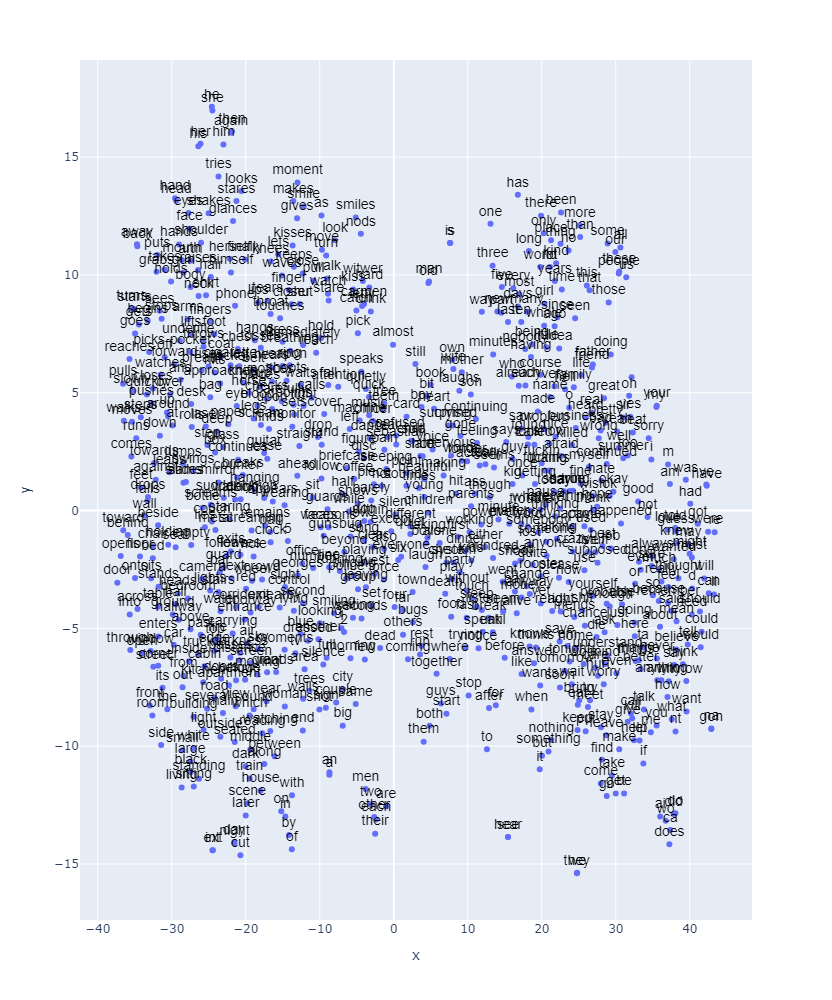

In [82]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           #color='pos_max', 
           hover_name='term_str',          
           #size='tfidf_sum',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')